In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

import numpy as np

from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)

from src.utils.constants import GenParamTuple# candidate_environments_args["n_environments"] = 50


np.set_printoptions(linewidth=160, precision=2)

from src.utils.environment_design import EnvironmentDesign

## Make true environment

Cliff World

In [2]:
# N, M = 4, 8

# agent_gamma = np.array(0.7)
# p_true= np.array(0.9)
# reward_true = np.array(0.8)

# agent_R = np.zeros((N, M))
# agent_R[0,1] = -1
# agent_R[0,2] = -1
# agent_R[0,3] = -1
# agent_R[0,4] = -1
# agent_R[0,5] = -1
# agent_R[0,6] = -1
# agent_R[0,7] = reward_true
# agent_R = agent_R.flatten()

# goal_states = np.where(agent_R != 0)[0]

# T = transition_matrix(N, M, p_true, absorbing_states=goal_states)

# #Define custom functions to generate reward, transition and gamma.
# def custom_transition_func(p):

#     _T = transition_matrix(N=4, M=8, p=p, absorbing_states=goal_states)
#     return _T

# def custom_gamma_func(gamma):
#     return gamma

# def custom_reward_func(reward):
#     agent_R = np.zeros((4, 8))
#     agent_R[0,1] = -1
#     agent_R[0,2] = -1
#     agent_R[0,3] = -1
#     agent_R[0,4] = -1
#     agent_R[0,5] = -1
#     agent_R[0,6] = -1
#     agent_R[0,7] = reward
#     return agent_R.flatten()

# #Create parameter ranges
# resolution = 15
# p_range = np.linspace(0.5, 0.95, resolution)
# gamma_range = np.linspace(0.5, 0.95, resolution)
# R_range = np.linspace(0.5, 0.95, resolution)

# gamma_range = gamma_range.reshape(1, resolution)
# p_range = p_range.reshape(1, resolution)
# R_range = R_range.reshape(1, resolution)



# p_true = p_true.reshape(1, 1)
# agent_gamma = agent_gamma.reshape(1, 1)
# reward_true = reward_true.reshape(1, 1)



# true_params = GenParamTuple(T = p_true, gamma=agent_gamma, R=reward_true)




# cliff = Environment(
#     N=N,
#     M=M,
#     reward_function = custom_reward_func,
#     transition_function=custom_transition_func,
#     gamma = custom_gamma_func,
#     wall_states=[],
#     start_state=0,
#     goal_states=goal_states
# )

In [18]:
# 0. Setup
N, M = 7,7



# Start by making the agent we want to learn the parameters of
agent_gamma = np.array(0.75)
p_true= np.array(0.92)
big_reward_true = np.array(0.5)

agent_R = np.zeros((N, M))
agent_R[N-1, 0] = 0.1
agent_R[N-1, M-1] = big_reward_true
agent_R = agent_R.flatten()

goal_states = np.where(agent_R != 0)[0]


wall_states = [14] #TODO: why do we need this

T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)


#Define custom functions to generate reward, transition and gamma.
def custom_transition_func(p):

    _T = transition_matrix(N=7, M=7, p=p, absorbing_states=goal_states)
    _T = insert_walls_into_T(T=_T, wall_indices=wall_states)
    return _T

def custom_gamma_func(gamma):
    return gamma

def custom_reward_func(big_reward):
    reward_func = np.zeros((N, M))
    reward_func[N-1, 0] = 0.1
    reward_func[N-1, M-1] = big_reward
    return reward_func.flatten()


#Create parameter ranges
resolution = 25
p_range = np.linspace(0.7, 0.95, resolution)
gamma_range = np.linspace(0.7, 0.95, resolution)
R_range = np.linspace(0.5, 0.95, resolution)


gamma_range = gamma_range.reshape(1, resolution)
p_range = p_range.reshape(1, resolution)
R_range = R_range.reshape(1, resolution)

p_true = p_true.reshape(1, 1)
agent_gamma = agent_gamma.reshape(1, 1)
big_reward_true = big_reward_true.reshape(1, 1)



true_params = GenParamTuple(T = p_true, gamma=agent_gamma, R=big_reward_true)




big_small = Environment(
    N=N,
    M=M,
    reward_function = custom_reward_func,
    transition_function=custom_transition_func,
    gamma = custom_gamma_func,
    wall_states=wall_states,
    start_state=0,
    goal_states=goal_states
)

In [19]:
env_design = EnvironmentDesign(base_environment=big_small, 
                               user_params=true_params, 
                               learn_what = ["gamma", "T"],
                               parameter_ranges_R=R_range,
                               parameter_ranges_gamma=gamma_range,
                               parameter_ranges_T=p_range)

Generated parameter mesh of shape:  (25, 25)


In [20]:
candidate_environments_args = {}
candidate_environments_args["generate_how"] = "entropy_BM"
candidate_environments_args["n_compute_BM"] = 50
candidate_environments_args["n_iterations_gradient"] = 3
candidate_environments_args["stepsize_gradient"] = 0.0001


env_design.run_n_episodes(n_episodes = 25,
                          candidate_environments_args=candidate_environments_args,
                          verbose=True)

/tmp/ipykernel_15416/547372801.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward_func[N-1, M-1] = big_reward


Started episode 0.
Finished episode 0.
Started episode 1.
Beginning calculation of log-likelihood. Calculating 625 samples.
Mean Parameters: [0.8167778624923978, 0.8293460927054269]
Computed Region of Interest. Size = 0.74
Finished BM Search. Entropy: 0.6868542425701539. Max Ent possible: 0.6931471805599453. Cover: {0: 0.44396551724137934, 1: 0.5560344827586207}. Behaviors: {0: [0, 7, 8, 15, 22, 29, 36, 43, 42], 1: [0, 1, 8, 15, 22, 29, 36, 43, 44, 45, 46, 47, 48]}
Behavior map:  ExperimentResult(data=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 

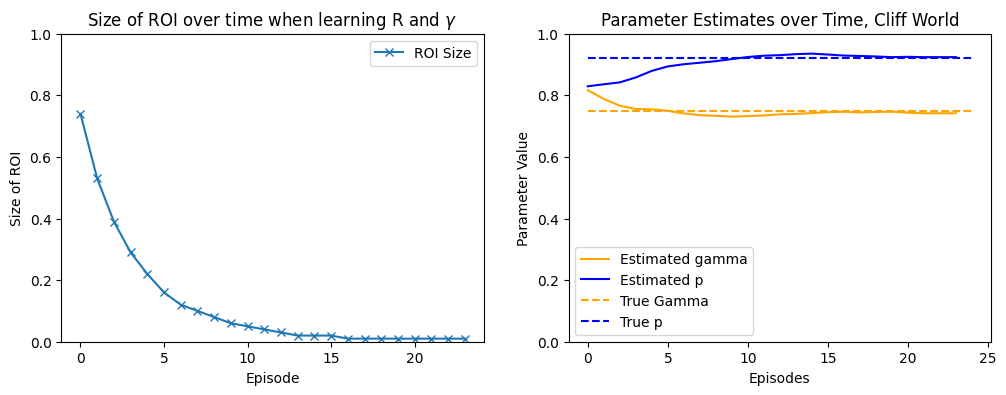

In [21]:
params = env_design.diagnostics["parameter_means"]
params = np.array(params)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

roi_sizes = env_design.diagnostics["ROI_sizes"]
roi_sizes = np.array(roi_sizes)
axs[0].plot(roi_sizes, "-x", label="ROI Size")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Size of ROI")
axs[0].set_ylim(0,1)
axs[0].legend()
axs[0].set_title("Size of ROI over time when learning R and $\gamma$")

axs[1].plot(params[:, 0], color="orange", label="Estimated gamma")
axs[1].plot(params[:, 1], color="blue", label="Estimated p")
axs[1].hlines(true_params.gamma, 0, params.shape[0], color="orange", linestyle="--", label="True Gamma")
axs[1].hlines(true_params.T, 0, params.shape[0], color="blue", linestyle="--", label="True p")
axs[1].set_ylim(0,1)
axs[1].set_title("Parameter Estimates over Time, Cliff World")
axs[1].set_xlabel("Episodes")
axs[1].set_ylabel("Parameter Value")
axs[1].legend()